# Worst Fit

#### Set path

In [2]:
# Define paths
REPO_PATH = r"C:\Users\Andre\projects\v1_v4_1024_elec" # set this
PROJECT_PATH = r'G:\Shared drives\v1_v4_1024'

#### Imports

In [56]:
# general
import numpy as np
import matplotlib.pyplot as plt
import os
import odml

# custom
import sys
sys.path.append(REPO_PATH)
from fooof import FOOOF, FOOOFGroup
from scripts.plots import plot_psd_diff

#### Settings

In [ ]:
# Session of interest (will ultimately apply to all sessions)
SESSIONS = ["A_SNR_041018", "A_SNR_140819", "L_SNR_250717"]
SESSION = "A_SNR_140819"

In [70]:
# Dataset details
FS = 500 # sampling frequency
N_ARRAYS = 16 # number of arrays

# SpecParam settings
FREQ_RANGE = [1, 100] 
N_JOBS = -1 # number of jobs for parallel processing
SPEC_PARAM_SETTINGS = {
    'peak_width_limits' :   [4, 20], # default: (0.5, 12.0)) - reccomends at least frequency resolution * 2
    'min_peak_height'   :   0.1, 
    'max_n_peaks'       :   4, # (default: inf)
    'peak_threshold'    :   2.0, # (default: 2.0)
    'aperiodic_mode'    :   'knee',
    'verbose'           :   False}

#### Functions

## Main

#### Create output directory

In [ ]:
# dir_out = f"{PROJECT_PATH}/figures/"
# if not os.path.exists(dir_out):
#     os.makedirs(dir_out)

#### Load data

In [ ]:
# # define odml file path (contains metadata including electrode positions)
# odml_path = fr"{PROJECT_PATH}\data\metadata\{SESSION}\metadata_{SESSION}.odml"
# metadata = odml.load(odml_path)

#### Find worst fit

In [22]:
# Initialize a FOOOFGroup object
fg_pre = FOOOFGroup()
fg_post = FOOOFGroup()
fg_pre.load(r"G:\Shared drives\v1_v4_1024\data\lfp\lfp_params\A_SNR_041018_lfp_pre.csv")
fg_post.load(r"G:\Shared drives\v1_v4_1024\data\lfp\lfp_params\A_SNR_041018_lfp_post.csv")

In [24]:
r_pre = fg_pre.get_params('r_squared')
r_post = fg_post.get_params('r_squared')

print("r_squaed pre values below 0.90:")
for i in r_pre :
    if i < 0.90 :
        print(i)
    else:
        continue

print("\n r_squaed post values below 0.90:")
for i in r_post :
    if i < 0.90 :
        print(i)
    else:
        continue

r_squaed pre values below 0.90:
0.8671814265659766
0.8417929279089499
0.7590637137183911
0.860281732508009
0.6902503259019094
0.7982953984260774
0.821354676883058
0.8216318560546101

 r_squaed post values below 0.90:


In [44]:
low_r_squared = np.argwhere(r_pre < 0.9).flatten()
low_r_squared

array([363, 366, 374, 376, 382, 616, 625, 626], dtype=int64)

In [89]:
r_pre[363]

0.8671814265659766

In [103]:
fm.fooofed_spectrum_.shape

(30,)

In [105]:
fm.freqs.shape

(30,)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 100 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     7.2665, 554.8473, 2.3825                                     
                                                                                                  
                                       0 peaks were found:                                        
          

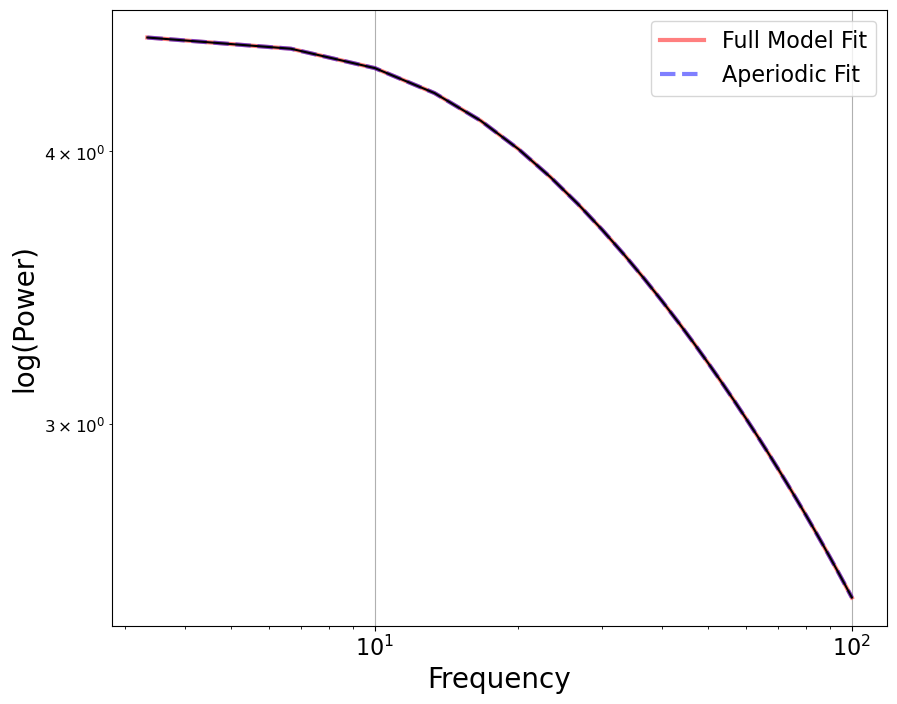

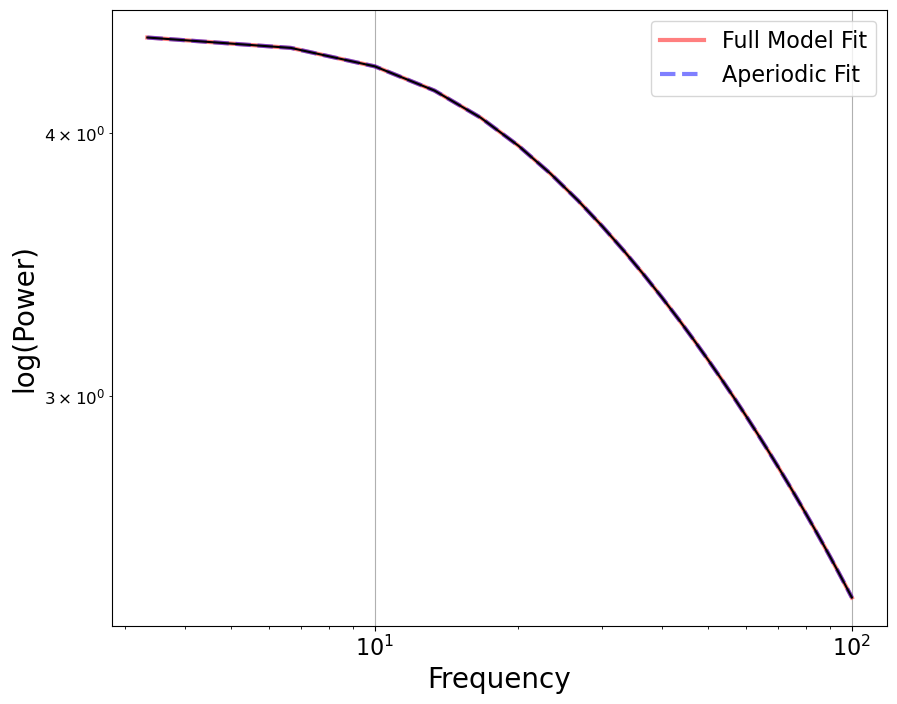

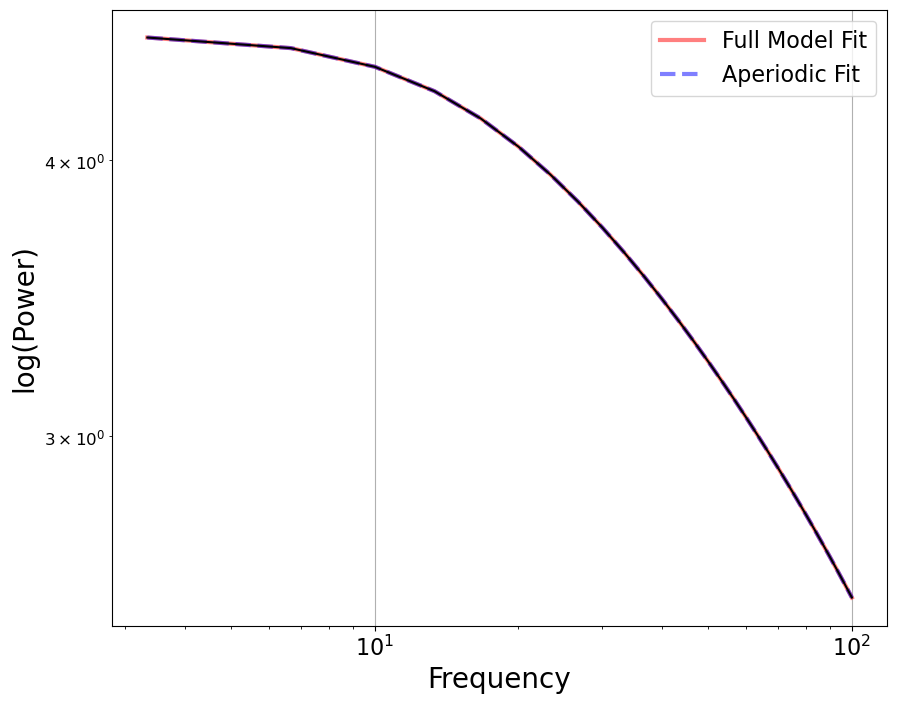

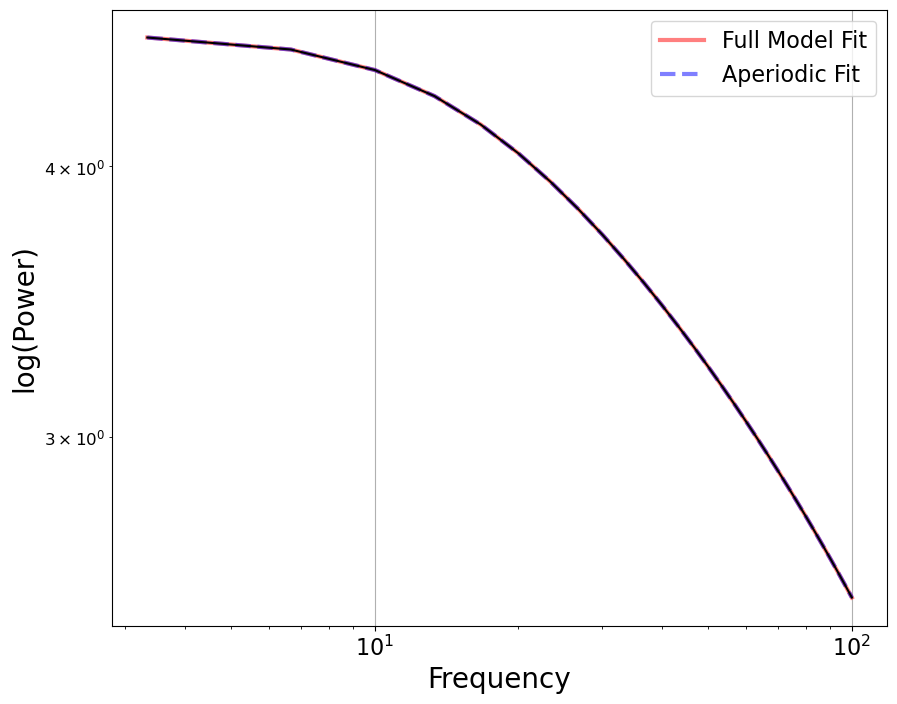

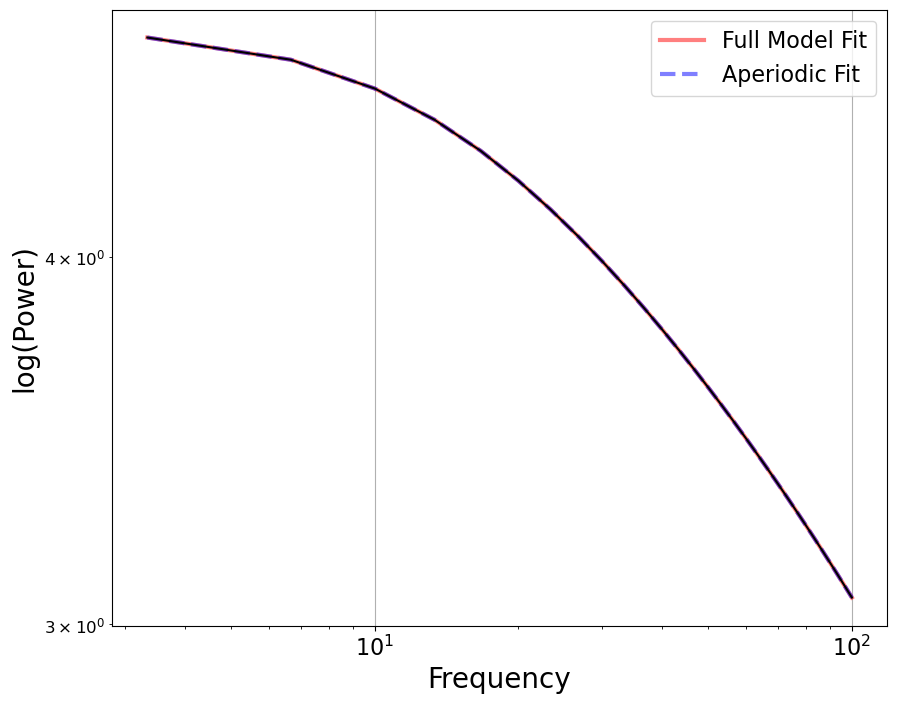

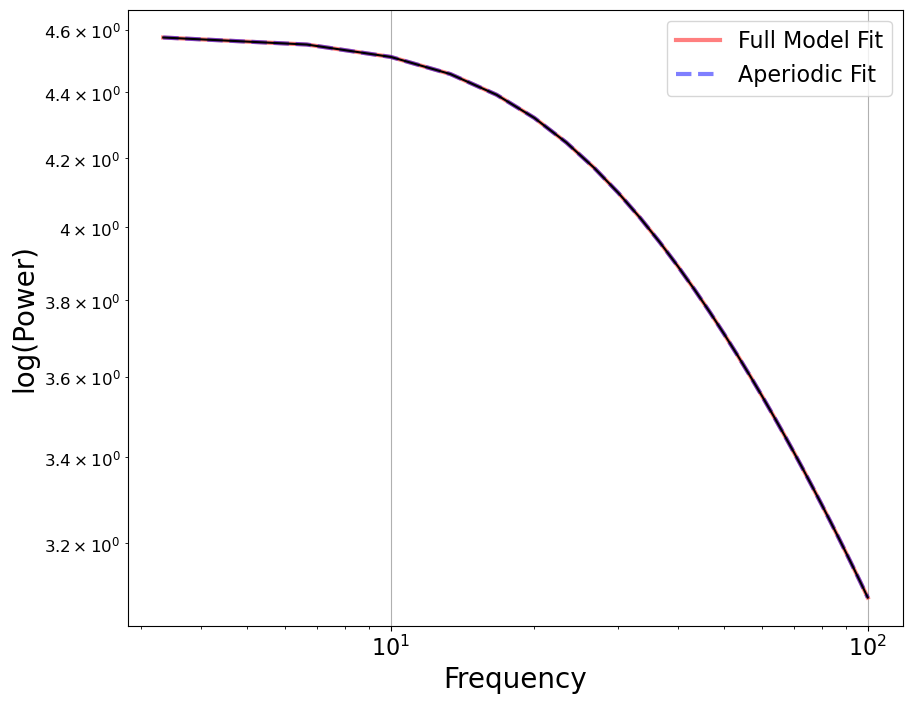

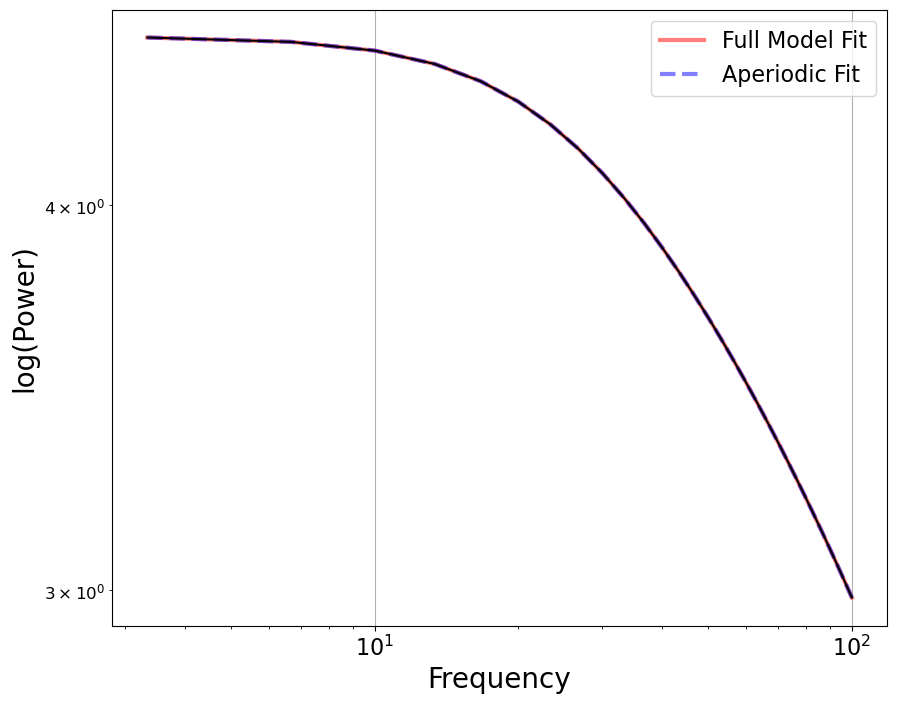

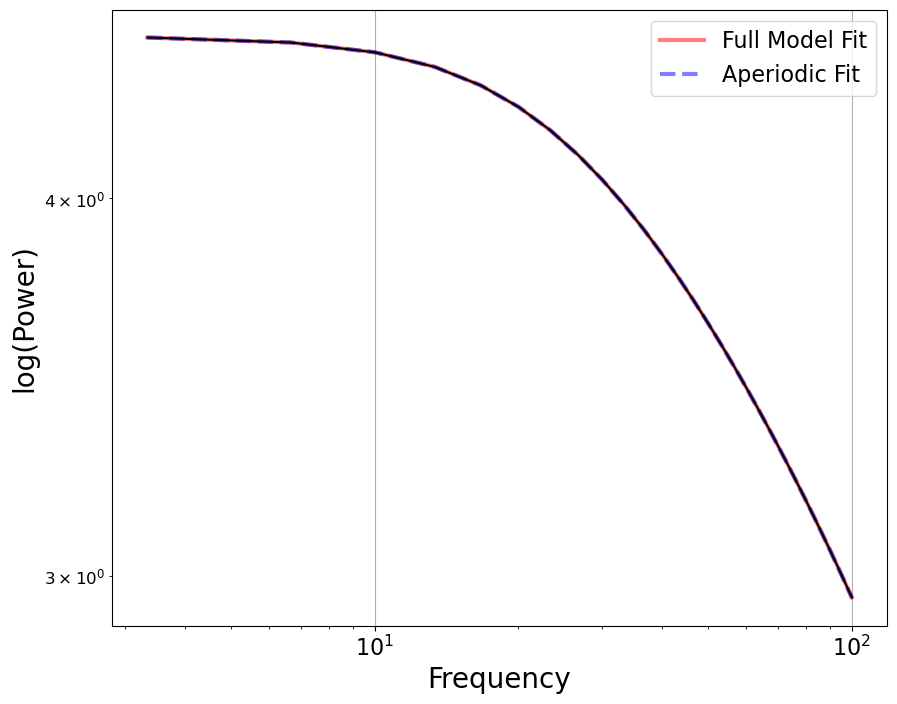

In [109]:
# Extract this model fit from the group
for val in low_r_squared:
    fm = fg_pre.get_fooof(val, regenerate=True)

    # Check results and visualize the extracted model
    fm.print_results()

    # plot
    fm.plot()
    spectrum = fm.fooofed_spectrum_
    freqs = fm.freqs
    ax = plt.gca()
    ax.plot(freqs, spectrum, color='k')
    ax.set(xscale='log', yscale='log')

#### Calculating max error psd

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 100 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     7.3503, 620.5792, 2.4053                                     
                                                                                                  
                                       0 peaks were found:                                        
          

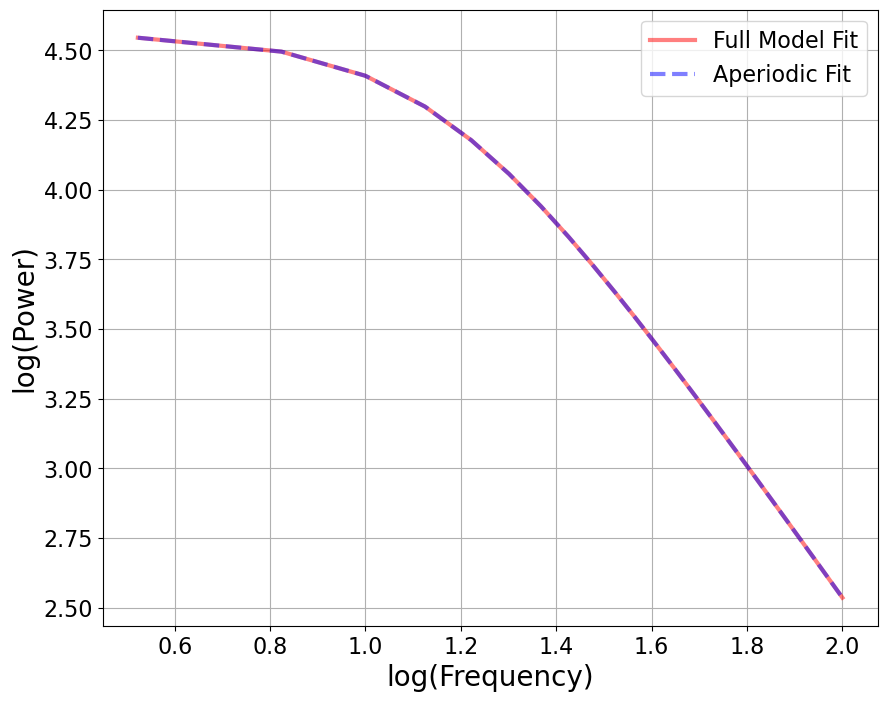

In [41]:
# Find the index of the worst model fit from the group
worst_fit_ind = np.argmax(fg_pre.get_params('error'))

# Extract this model fit from the group
fm = fg_pre.get_fooof(worst_fit_ind, regenerate=True)

# Check results and visualize the extracted model
fm.print_results()
fm.plot(plt_log=True)

In [51]:
# aggregate PSDs across arrays, compute difference and plot

# initialize
psd_pre_list = []
psd_post_list = []

# loop over sessions
for i_array in range(N_ARRAYS):
    # load psd
    nps_idx = (i_array+2) // 2
    fname_in = f"{PROJECT_PATH}/data/lfp/lfp_psd/A_SNR_041018/NSP{nps_idx}_array{i_array+1}_LFP_XXX.npz"
    psd_pre_list.append(np.load(fname_in.replace('XXX', 'pre'))['spectra'])
    psd_post_list.append(np.load(fname_in.replace('XXX', 'post'))['spectra'])

# get freq vector
freq = np.load(fname_in.replace('XXX', 'pre'))['freq']

# join psds across arrays into single array
psd_pre = np.concatenate(psd_pre_list, axis=1)
psd_post = np.concatenate(psd_post_list, axis=1)

In [81]:
#fg.fit(freq,spectra)
# Average over trials (average psd_pre frequency)
psd_pre_avg = np.mean(psd_pre, axis = 0)

# index channels for worst one
worst_fit_spec = psd_pre_avg[worst_fit_ind]
worst_fit_spec

# fit fooof model
fg_worst = FOOOF(**SPEC_PARAM_SETTINGS)
fg_worst.fit(freq, worst_fit_spec, freq_range=FREQ_RANGE)

In [72]:
print(f"worst_fit_spec: {worst_fit_spec.shape} \nfreq: {freq.shape}")

worst_fit_spec: (76,) 
freq: (76,)


In [82]:
# compare results to ones above in gorup object
fm.print_results()
fg_worst.print_results()


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 100 Hz                        
                                 Frequency Resolution is 3.33 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     7.2665, 554.8473, 2.3825                                     
                                                                                                  
                                       0 peaks were found:                                        
          

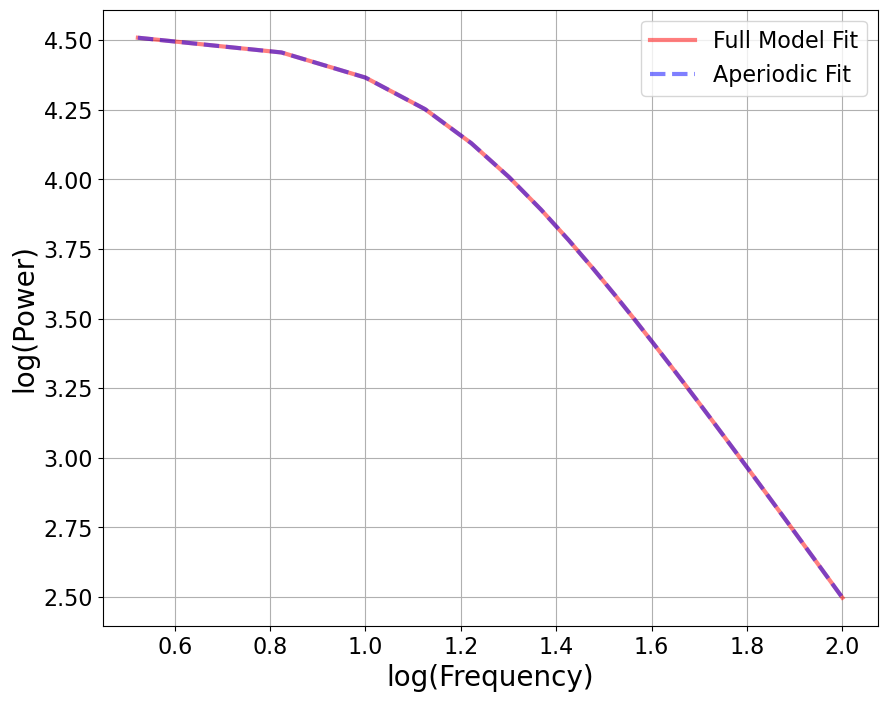

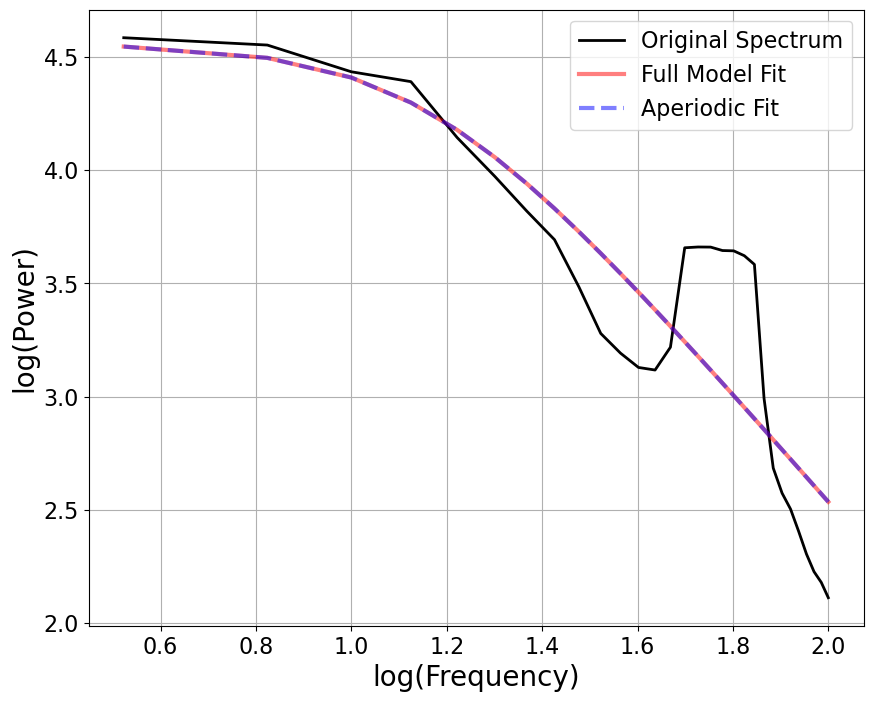

In [84]:
fm.plot(plt_log=True)
fg_worst.plot(plt_log=True)

In [94]:
fg.save('test.csv', save_results=True)
fg.save('test', save_results=True)

In [95]:
fg_from_csv = fg.load('test.csv')
fg_from_json = fg.load('test.json')

In [96]:
fg_from_csv==fg_from_json

True